In [4]:
# 기본 라이브러리
import os
import json
import shutil
import torch
import torch.utils.data as data
from data_loader import get_segmentation_dataset  # 데이터셋 로드 함수
from utils.metric import SegmentationMetric  # 평가 지표\
from torchvision import transforms

import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

# PyTorch 관련 라이브러리
import torch.utils.data as data
import torch.backends.cudnn as cudnn

# 이미지 변환 관련 라이브러리
from torchvision import transforms

# 데이터 로더 및 모델, 유틸리티 함수 불러오기
from data_loader import get_segmentation_dataset  # 데이터셋 불러오는 함수
from utils.loss import MixSoftmaxCrossEntropyLoss, MixSoftmaxCrossEntropyOHEMLoss  # 손실 함수
from utils.lr_scheduler import LRScheduler  # 학습률 스케줄러
from utils.metric import SegmentationMetric  # 평가 지표

from modules import conv3x3, conv1x1, DWConvBNAct, PWConvBNAct, ConvBNAct, Activation, SegHead
from model_registry import register_model, aux_models

# Python 모듈 경로에 'models' 폴더 추가
models_path = "/home/segmentsafestep/Fast-SCNN-pytorch-master/models"

if models_path not in sys.path:
    sys.path.append(models_path)  # models 폴더 추가
    
# sys.path 확인 (제대로 추가되었는지)
print("Python 경로 목록:")
print("\n".join(sys.path))

Python 경로 목록:
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python39.zip
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/lib-dynload

/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/site-packages
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/site-packages/IPython/extensions
/home/segmentsafestep/.ipython
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/site-packages/setuptools/_vendor
/home/segmentsafestep/Fast-SCNN-pytorch-master/models


## bisenetv2 클래스 22개

In [6]:
# BiSeNetV2 모델 정의
@register_model(aux_models)  # 모델을 등록하는 Decorator (사용자 정의 모델 등록을 위한 코드)
class BiSeNetv2(nn.Module):
    def __init__(self, num_class=1, n_channel=3, act_type='relu', use_aux=True):
        super().__init__()
        self.use_aux = use_aux  # 보조 분류(head) 사용 여부 설정 (True일 경우 보조 출력 사용)

        # 상세한 특징을 추출하는 Branch
        self.detail_branch = DetailBranch(n_channel, 128, act_type)

        # 의미론적 특징(Semantic Feature)을 추출하는 Branch
        self.semantic_branch = SemanticBranch(n_channel, 128, num_class, act_type, use_aux)

        # 두 개의 Branch에서 나온 특징을 합치는 Layer
        self.bga_layer = BilateralGuidedAggregationLayer(128, 128, act_type)

        # 최종 Segmentation 결과를 출력하는 Segmentation Head
        self.seg_head = SegHead(128, num_class, act_type)

    def forward(self, x, is_training=False):
        size = x.size()[2:]  # 원본 입력 크기 저장 (업샘플링에 사용)
        x_d = self.detail_branch(x)  # Detail Branch 실행 (미세한 특징 추출)

        # 보조 분류 사용 여부에 따라 처리 방식 결정
        if self.use_aux:
            x_s, aux2, aux3, aux4, aux5 = self.semantic_branch(x)  # Semantic Branch 실행
        else:
            x_s = self.semantic_branch(x)

        x = self.bga_layer(x_d, x_s)  # 두 개의 Branch 출력 합성
        x = self.seg_head(x)  # 최종 Segmentation 결과 출력
        x = F.interpolate(x, size, mode='bilinear', align_corners=True)  # 원본 크기로 업샘플링

        # 보조 분류 사용 여부에 따라 추가 보조 출력 반환
        if self.use_aux and is_training:
            return x, (aux2, aux3, aux4, aux5)
        else:
            return x
        
# Detail Branch: 고해상도 특징을 유지하면서 세부 정보를 추출
class DetailBranch(nn.Sequential):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__(
            ConvBNAct(in_channels, 64, 3, 2, act_type=act_type),  # 입력 채널 → 64 채널 변환, 다운샘플링
            ConvBNAct(64, 64, 3, 1, act_type=act_type),  # Conv 연산 (필터 유지)
            ConvBNAct(64, 64, 3, 2, act_type=act_type),  # 다운샘플링
            ConvBNAct(64, 64, 3, 1, act_type=act_type),  # Conv 연산
            ConvBNAct(64, 128, 3, 1, act_type=act_type),  # 채널 확장
            ConvBNAct(128, 128, 3, 2, act_type=act_type),  # 다운샘플링
            ConvBNAct(128, 128, 3, 1, act_type=act_type),  # Conv 연산
            ConvBNAct(128, out_channels, 3, 1, act_type=act_type)  # 최종 출력
        )
        
# Semantic Branch: 저해상도 특징을 추출하면서 의미론적 정보를 학습
class SemanticBranch(nn.Sequential):
    def __init__(self, in_channels, out_channels, num_class, act_type='relu', use_aux=False):
        super().__init__()
        self.use_aux = use_aux  # 보조 출력을 사용할지 여부

        # 첫 번째 단계: 초기 Feature 추출
        self.stage1to2 = StemBlock(in_channels, 16, act_type)

        # 두 번째 단계: 저해상도 특징 추출
        self.stage3 = nn.Sequential(
            GatherExpansionLayer(16, 32, 2, act_type),  # 다운샘플링 (16 → 32 채널)
            GatherExpansionLayer(32, 32, 1, act_type),  # Conv 연산
        )

        self.stage4 = nn.Sequential(
            GatherExpansionLayer(32, 64, 2, act_type),  # 다운샘플링 (32 → 64 채널)
            GatherExpansionLayer(64, 64, 1, act_type),  # Conv 연산
        )

        self.stage5_1to4 = nn.Sequential(
            GatherExpansionLayer(64, 128, 2, act_type),  # 다운샘플링 (64 → 128 채널)
            GatherExpansionLayer(128, 128, 1, act_type),
            GatherExpansionLayer(128, 128, 1, act_type),
            GatherExpansionLayer(128, 128, 1, act_type),
        )

        self.stage5_5 = ContextEmbeddingBlock(128, out_channels, act_type)  # 글로벌 컨텍스트 학습

        # 보조 분류기 정의 (auxiliary segmentation heads)
        if self.use_aux:
            self.seg_head2 = SegHead(16, num_class, act_type)
            self.seg_head3 = SegHead(32, num_class, act_type)
            self.seg_head4 = SegHead(64, num_class, act_type)
            self.seg_head5 = SegHead(128, num_class, act_type)

    def forward(self, x):
        x = self.stage1to2(x)
        if self.use_aux:
            aux2 = self.seg_head2(x)

        x = self.stage3(x)
        if self.use_aux:
            aux3 = self.seg_head3(x)

        x = self.stage4(x)
        if self.use_aux:
            aux4 = self.seg_head4(x)

        x = self.stage5_1to4(x)
        if self.use_aux:
            aux5 = self.seg_head5(x)

        x = self.stage5_5(x)  # 최종 의미론적 정보 추출

        if self.use_aux:
            return x, aux2, aux3, aux4, aux5
        else:
            return x
        
class StemBlock(nn.Module):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__()
        self.conv_init = ConvBNAct(in_channels, out_channels, 3, 2, act_type=act_type)
        self.left_branch = nn.Sequential(
                            ConvBNAct(out_channels, out_channels//2, 1, act_type=act_type),
                            ConvBNAct(out_channels//2, out_channels, 3, 2, act_type=act_type)
                    )
        self.right_branch = nn.MaxPool2d(3, 2, 1)
        self.conv_last = ConvBNAct(out_channels*2, out_channels, 3, 1, act_type=act_type)

    def forward(self, x):
        x = self.conv_init(x)
        x_left = self.left_branch(x)
        x_right = self.right_branch(x)
        x = torch.cat([x_left, x_right], dim=1)
        x = self.conv_last(x)

        return x
    
class GatherExpansionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride, act_type='relu', expand_ratio=6,):
        super().__init__()
        self.stride = stride
        hid_channels = int(round(in_channels * expand_ratio))

        layers = [ConvBNAct(in_channels, in_channels, 3, act_type=act_type)]

        if stride == 2:
            layers.extend([
                            DWConvBNAct(in_channels, hid_channels, 3, 2, act_type='none'),
                            DWConvBNAct(hid_channels, hid_channels, 3, 1, act_type='none')
                        ])
            self.right_branch = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, 2, act_type='none'),
                                    PWConvBNAct(in_channels, out_channels, act_type='none')
                            )
        else:
            layers.append(DWConvBNAct(in_channels, hid_channels, 3, 1, act_type='none'))

        layers.append(PWConvBNAct(hid_channels, out_channels, act_type='none'))
        self.left_branch = nn.Sequential(*layers)
        self.act = Activation(act_type)

    def forward(self, x):
        res = self.left_branch(x)

        if self.stride == 2:
            res = self.right_branch(x) + res
        else:
            res = x + res

        return self.act(res)
    
class ContextEmbeddingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__()
        self.pool = nn.Sequential(
                            nn.AdaptiveAvgPool2d(1),
                            nn.BatchNorm2d(in_channels)
                    )
        self.conv_mid = ConvBNAct(in_channels, in_channels, 1, act_type=act_type)
        self.conv_last = conv3x3(in_channels, out_channels)

    def forward(self, x):
        res = self.pool(x)
        res = self.conv_mid(res)
        x = res + x
        x = self.conv_last(x)

        return x
    
class BilateralGuidedAggregationLayer(nn.Module):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__()
        self.detail_high = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, act_type=act_type),
                                    conv1x1(in_channels, in_channels)
                        )
        self.detail_low = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, 2, act_type=act_type),
                                    nn.AvgPool2d(3, 2, 1)
                        )
        self.semantic_high = nn.Sequential(
                                    ConvBNAct(in_channels, in_channels, 3, act_type=act_type),
                                    nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True),
                                    nn.Sigmoid()
                            )
        self.semantic_low = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, act_type=act_type),
                                    conv1x1(in_channels, in_channels),
                                    nn.Sigmoid()
                            )
        self.conv_last = ConvBNAct(in_channels, out_channels, 3, act_type=act_type)

    def forward(self, x_d, x_s):
        x_d_high = self.detail_high(x_d)
        x_d_low = self.detail_low(x_d)

        x_s_high = self.semantic_high(x_s)
        x_s_low = self.semantic_low(x_s)
        x_high = x_d_high * x_s_high
        x_low = x_d_low * x_s_low

        size = x_high.size()[2:]
        x_low = F.interpolate(x_low, size, mode='bilinear', align_corners=True)
        res = x_high + x_low
        res = self.conv_last(res)

        return res

# 클래스 22개
model = BiSeNetv2(num_class=22)

# GPU 자동 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델을 GPU 또는 CPU로 옮기기
model = model.to(device)

In [7]:
# 설정 (Jupyter Notebook 환경에 맞게 변경)
args = {
    "dataset": "surface",  # 사용할 데이터셋 (Cityscapes)
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),  # GPU/CPU 설정
    "batch_size": 1,  # 평가 시 배치 크기
    "num_workers": 0,  # DataLoader의 worker 개수 (메모리 문제 방지 위해 0으로 설정)
    "weight_path": "/home/segmentsafestep/Fast-SCNN-pytorch-master/weights/indobohaeng pretraining/model_indobohaeng_why25.pth"  # 저장된 가중치 경로
}

# 가중치 파일 확인
if not os.path.exists(args["weight_path"]):
    raise FileNotFoundError(f"가중치 파일이 존재하지 않습니다: {args['weight_path']}")

# 이미지 전처리 설정
input_transform = transforms.Compose([
    transforms.ToPILImage(),                      # numpy → PIL
    transforms.Resize((640, 640)),  # <- 추가: 32의 배수로 강제 resize
    transforms.ToTensor(),
    transforms.Normalize([0.3257, 0.3690, 0.3223], [0.2112, 0.2148, 0.2115]),  # 이미지 정규화
])

# 검증 데이터셋 로드 (Cityscapes val set)
val_dataset = get_segmentation_dataset(args["dataset"], split="val", mode="testval", transform=input_transform, root="/home/segmentsafestep/Fast-SCNN-pytorch-master/datasets")
val_loader = data.DataLoader(
    dataset=val_dataset,
    batch_size=args["batch_size"],
    shuffle=False,
    num_workers=args["num_workers"]
)

# 모델 및 가중치 로드
# model = BiSeNetv2(num_class=val_dataset.num_class).to(args["device"])  # 모델 생성

# 저장된 가중치 파일 로드
checkpoint = torch.load(args["weight_path"], map_location=args["device"])

# 가중치 파일에 state_dict가 포함되어 있으면, 모델 가중치만 추출하여 로드
if "state_dict" in checkpoint:
    model.load_state_dict(checkpoint["state_dict"])  # state_dict만 로드
else:
    model.load_state_dict(checkpoint)  # 이미 순수한 가중치 파일이면 그대로 로드

model.eval()  # 모델을 평가 모드로 설정
print("모델 및 가중치 로드 완료!")

# 평가 지표 설정 (mIoU 및 픽셀 정확도)
metric = SegmentationMetric(val_dataset.num_class)

cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045448.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel_sur_045448.png
cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045451.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel_sur_045451.png
cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045466.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel_sur_045466.png
cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045472.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel

## 클래스 별 iou와 miou 계산

In [5]:
print(f"val_dataset.num_class: {val_dataset.num_class}")

val_dataset.num_class: 22


In [6]:
## 이걸로 실행시켜야해
import os
import json
import torch
import random
import numpy as np
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Subset
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# 설정
args = {
    "dataset": "surface",
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "batch_size": 1,
    "num_workers": 0,
    "weight_dir": "/home/segmentsafestep/Fast-SCNN-pytorch-master/weights"
}

# 전처리
input_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.3257, 0.3690, 0.3223], [0.2112, 0.2148, 0.2115]),
])

# ✅ SegmentationMetric 클래스 정의
class SegmentationMetric(object):
    def __init__(self, numClass):
        self.numClass = numClass
        self.confusion_matrix = np.zeros((self.numClass,) * 2)

    def update(self, preds, labels):
        mask = (labels >= 0) & (labels < self.numClass)
        hist = np.bincount(
            self.numClass * labels[mask].astype(int) + preds[mask],
            minlength=self.numClass ** 2
        ).reshape(self.numClass, self.numClass)
        self.confusion_matrix += hist

    def get(self):
        acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        iu = np.diag(self.confusion_matrix) / (
            self.confusion_matrix.sum(1) + self.confusion_matrix.sum(0) - np.diag(self.confusion_matrix) + 1e-10
        )
        mean_iu = np.nanmean(iu)
        return acc, mean_iu

    def get_class_iou(self):
        iu = np.diag(self.confusion_matrix) / (
            self.confusion_matrix.sum(1) + self.confusion_matrix.sum(0) - np.diag(self.confusion_matrix) + 1e-10
        )
        return iu

    def reset(self):
        self.confusion_matrix = np.zeros((self.numClass,) * 2)

# 전체 val 데이터셋 로드
val_dataset = get_segmentation_dataset(
    args["dataset"], split="val", mode="testval",
    transform=input_transform,
    root="/home/segmentsafestep/Fast-SCNN-pytorch-master/datasets"
)

# ✅ 랜덤 500개 샘플 추출
random.seed(42)
sample_indices = random.sample(range(len(val_dataset)), 500)
val_subset = Subset(val_dataset, sample_indices)

# DataLoader
val_loader = data.DataLoader(
    dataset=val_subset,
    batch_size=args["batch_size"],
    shuffle=False,
    num_workers=args["num_workers"]
)

# 평가 결과 저장용
eval_history = []

# 평가 루프
for epoch in range(22, 25):
    weight_path = os.path.join(args["weight_dir"], f"model_indobohaeng_why{epoch}.pth")
    if not os.path.exists(weight_path):
        print(f"{weight_path} 없음, 스킵")
        continue

    checkpoint = torch.load(weight_path, map_location=args["device"])
    if "state_dict" in checkpoint:
        model.load_state_dict(checkpoint["state_dict"])
    else:
        model.load_state_dict(checkpoint)
    model.eval()

    metric = SegmentationMetric(val_dataset.num_class)
    with torch.no_grad():
        for image, label in tqdm(val_loader, desc=f"Epoch {epoch} evaluating 500 samples"):
            image = image.to(args["device"])
            label = label.to("cpu")

            outputs = model(image)
            if outputs.shape[-2:] != label.shape[-2:]:
                outputs = F.interpolate(outputs, size=label.shape[-2:], mode='bilinear', align_corners=False)

            pred = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()
            label = label.squeeze(0).cpu().numpy()

            metric.update(pred, label)

    pixAcc, mIoU = metric.get()

    # 🎉 클래스별 IoU 출력 및 저장
    class_iou = metric.get_class_iou()
    for idx, iou in enumerate(class_iou):
        print(f"[Epoch {epoch}] Class {idx} IoU: {iou * 100:.2f}%")

    print(f"[Epoch {epoch}] Pixel Accuracy: {pixAcc * 100:.2f}%, mIoU: {mIoU * 100:.2f}%")

    eval_history.append({
        "epoch": epoch,
        "pixel_accuracy": round(pixAcc, 6),
        "mean_iou": round(mIoU, 6),
        "class_iou": [round(i, 6) for i in class_iou.tolist()]
    })

# 결과 저장
os.makedirs("./eval_results", exist_ok=True)
with open("./eval_results/val_metrics_history_01.json", "w") as f:
    json.dump(eval_history, f, indent=4)
print("✅ 500개 샘플 기준 평가 완료 및 저장됨!")
## 이거 돌려야해

cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045448.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel_sur_045448.png
cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045451.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel_sur_045451.png
cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045466.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel_sur_045466.png
cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045472.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel

Epoch 22 evaluating 500 samples: 100%|████████████████████████████████████████████| 500/500 [13:16<00:00,  1.59s/it]


[Epoch 22] Class 0 IoU: 63.25%
[Epoch 22] Class 1 IoU: 0.42%
[Epoch 22] Class 2 IoU: 15.51%
[Epoch 22] Class 3 IoU: 0.90%
[Epoch 22] Class 4 IoU: 0.00%
[Epoch 22] Class 5 IoU: 0.00%
[Epoch 22] Class 6 IoU: 0.00%
[Epoch 22] Class 7 IoU: 43.55%
[Epoch 22] Class 8 IoU: 0.00%
[Epoch 22] Class 9 IoU: 6.93%
[Epoch 22] Class 10 IoU: 0.00%
[Epoch 22] Class 11 IoU: 79.21%
[Epoch 22] Class 12 IoU: 41.09%
[Epoch 22] Class 13 IoU: 60.31%
[Epoch 22] Class 14 IoU: 0.00%
[Epoch 22] Class 15 IoU: 4.33%
[Epoch 22] Class 16 IoU: 0.00%
[Epoch 22] Class 17 IoU: 29.12%
[Epoch 22] Class 18 IoU: 8.55%
[Epoch 22] Class 19 IoU: 42.60%
[Epoch 22] Class 20 IoU: 0.00%
[Epoch 22] Class 21 IoU: 58.80%
[Epoch 22] Pixel Accuracy: 80.09%, mIoU: 20.66%


Epoch 23 evaluating 500 samples: 100%|████████████████████████████████████████████| 500/500 [13:20<00:00,  1.60s/it]


[Epoch 23] Class 0 IoU: 61.94%
[Epoch 23] Class 1 IoU: 1.21%
[Epoch 23] Class 2 IoU: 14.04%
[Epoch 23] Class 3 IoU: 5.43%
[Epoch 23] Class 4 IoU: 0.00%
[Epoch 23] Class 5 IoU: 0.00%
[Epoch 23] Class 6 IoU: 0.00%
[Epoch 23] Class 7 IoU: 24.16%
[Epoch 23] Class 8 IoU: 0.00%
[Epoch 23] Class 9 IoU: 16.70%
[Epoch 23] Class 10 IoU: 0.00%
[Epoch 23] Class 11 IoU: 81.39%
[Epoch 23] Class 12 IoU: 50.25%
[Epoch 23] Class 13 IoU: 63.71%
[Epoch 23] Class 14 IoU: 0.00%
[Epoch 23] Class 15 IoU: 3.47%
[Epoch 23] Class 16 IoU: 0.00%
[Epoch 23] Class 17 IoU: 32.54%
[Epoch 23] Class 18 IoU: 10.21%
[Epoch 23] Class 19 IoU: 42.39%
[Epoch 23] Class 20 IoU: 0.00%
[Epoch 23] Class 21 IoU: 63.99%
[Epoch 23] Pixel Accuracy: 81.08%, mIoU: 21.43%


Epoch 24 evaluating 500 samples: 100%|████████████████████████████████████████████| 500/500 [13:28<00:00,  1.62s/it]

[Epoch 24] Class 0 IoU: 63.18%
[Epoch 24] Class 1 IoU: 2.25%
[Epoch 24] Class 2 IoU: 16.70%
[Epoch 24] Class 3 IoU: 1.50%
[Epoch 24] Class 4 IoU: 0.00%
[Epoch 24] Class 5 IoU: 0.00%
[Epoch 24] Class 6 IoU: 0.00%
[Epoch 24] Class 7 IoU: 28.57%
[Epoch 24] Class 8 IoU: 0.00%
[Epoch 24] Class 9 IoU: 11.29%
[Epoch 24] Class 10 IoU: 0.00%
[Epoch 24] Class 11 IoU: 79.88%
[Epoch 24] Class 12 IoU: 54.01%
[Epoch 24] Class 13 IoU: 64.21%
[Epoch 24] Class 14 IoU: 0.00%
[Epoch 24] Class 15 IoU: 3.49%
[Epoch 24] Class 16 IoU: 0.00%
[Epoch 24] Class 17 IoU: 26.46%
[Epoch 24] Class 18 IoU: 13.20%
[Epoch 24] Class 19 IoU: 41.38%
[Epoch 24] Class 20 IoU: 0.00%
[Epoch 24] Class 21 IoU: 68.39%
[Epoch 24] Pixel Accuracy: 81.31%, mIoU: 21.57%
✅ 500개 샘플 기준 평가 완료 및 저장됨!


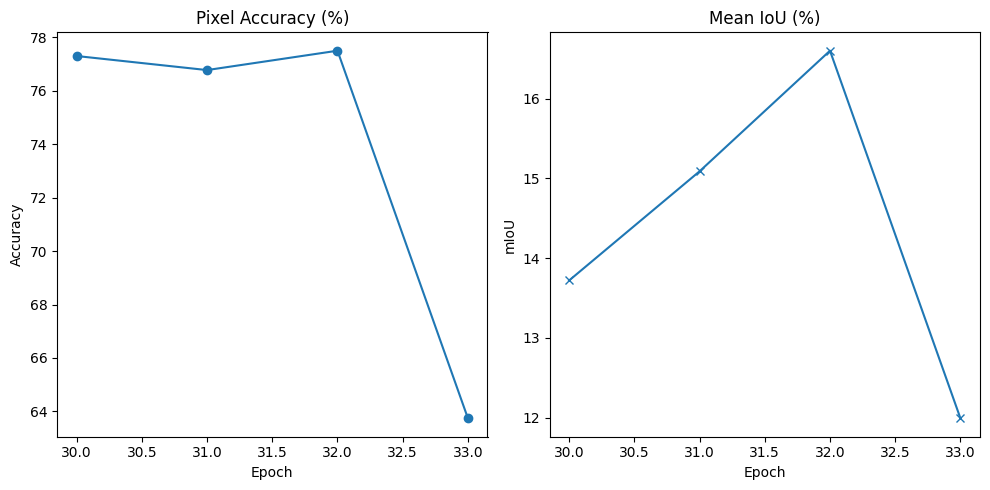

In [1]:
import json
import matplotlib.pyplot as plt

# JSON 파일 경로
json_path = "./eval_results/val_metrics_history_01.json"

# JSON 로드
with open(json_path, "r") as f:
    eval_history = json.load(f)

# 그래프 그리기
epochs = [x["epoch"] for x in eval_history]
pix_accs = [x["pixel_accuracy"] * 100 for x in eval_history]
mious = [x["mean_iou"] * 100 for x in eval_history]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, pix_accs, marker='o')
plt.title("Pixel Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs, mious, marker='x')
plt.title("Mean IoU (%)")
plt.xlabel("Epoch")
plt.ylabel("mIoU")

plt.tight_layout()
plt.show()

---

### 원본 코드

In [7]:
# 기본 라이브러리
import os
import torch
import torch.utils.data as data
from torchvision import transforms
from data_loader import get_segmentation_dataset  # 데이터셋 로드 함수
from models.bisenetv2 import BiSeNetv2  # BiSeNetv2 모델
from utils.metric import SegmentationMetric  # 평가 지표

In [8]:
# 설정 (Jupyter Notebook 환경에 맞게 변경)
args = {
    "dataset": "citys",  # 사용할 데이터셋 (Cityscapes)
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),  # GPU/CPU 설정
    "batch_size": 1,  # 평가 시 배치 크기
    "num_workers": 0,  # DataLoader의 worker 개수 (메모리 문제 방지 위해 0으로 설정)
    "weight_path": "/aiffel/aiffel/aiffel project model training/Fast-SCNN-pytorch-master/weights/bisenetv2-aux.pth"  # 저장된 가중치 경로
}

In [9]:
# 가중치 파일 확인
if not os.path.exists(args["weight_path"]):
    raise FileNotFoundError(f"가중치 파일이 존재하지 않습니다: {args['weight_path']}")

# 이미지 전처리 설정
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])

In [11]:
# 검증 데이터셋 로드 (Cityscapes val set)
val_dataset = get_segmentation_dataset(args["dataset"], split="val", mode="testval", transform=input_transform)
val_loader = data.DataLoader(
    dataset=val_dataset,
    batch_size=args["batch_size"],
    shuffle=False,
    num_workers=args["num_workers"]
)

# 모델 로드 및 가중치 적용
num_classes = val_dataset.num_class  # 클래스 개수 가져오기
model = BiSeNetv2(num_class=num_classes).to(args["device"])  # 모델 생성

# 저장된 가중치 파일 로드
checkpoint = torch.load(args["weight_path"], map_location=args["device"])

# 가중치 파일에 state_dict가 포함되어 있으면, 모델 가중치만 추출하여 로드
if "state_dict" in checkpoint:
    model.load_state_dict(checkpoint["state_dict"])  # state_dict만 로드
else:
    model.load_state_dict(checkpoint)  # 이미 순수한 가중치 파일이면 그대로 로드

model.eval()  # 모델을 평가 모드로 설정
print("모델 및 가중치 로드 완료!")

# 평가 지표 설정 (mIoU 및 픽셀 정확도)
metric = SegmentationMetric(val_dataset.num_class)

Found 500 images in /aiffel/aiffel/aiffel project model training/Fast-SCNN-pytorch-master/datasets/citys/leftImg8bit/val
모델 및 가중치 로드 완료!


In [12]:
# 검증 수행 및 mIoU 계산
print("검증 데이터셋 평가 중...")
with torch.no_grad():
    for i, (image, label) in enumerate(val_loader):
        image = image.to(args["device"])
        label = label.cpu().numpy().squeeze()  # GPU -> CPU 후 불필요한 차원 제거

        # 모델 예측 수행
        outputs = model(image)

        # 모델 출력이 (C, W)로 잘못 나오는 경우, 올바르게 변환
        if len(outputs.shape) == 3:  # (C, H, W) 형태라면 batch 차원이 없음 -> 추가
            outputs = outputs.unsqueeze(0)  # (1, C, H, W) 형태로 변환
        elif len(outputs.shape) == 2:  # (C, W) 형태라면 차원 재배열 필요
            outputs = outputs.view(1, outputs.shape[0], 1, outputs.shape[1])  # (1, C, 1, W)로 변환
        
        # 예측 결과 계산
        pred = torch.argmax(outputs, dim=1).cpu().numpy().squeeze()  # (H, W) 형태로 변환
        
        # 평가 지표 업데이트
        metric.update(pred, label)

        # 10개마다 중간 결과 출력
        if (i + 1) % 10 == 0:
            pixAcc, mIoU = metric.get()
            print(f"Sample {i+1}: Pixel Accuracy = {pixAcc * 100:.2f}%, mIoU = {mIoU * 100:.2f}%")

# 최종 평가 결과 출력
final_pixAcc, final_mIoU = metric.get()
print("\n최종 평가 결과")
print(f"Pixel Accuracy: {final_pixAcc * 100:.2f}%")
print(f"Mean IoU (mIoU): {final_mIoU * 100:.2f}%")

검증 데이터셋 평가 중...
Sample 10: Pixel Accuracy = 94.43%, mIoU = 65.34%
Sample 20: Pixel Accuracy = 95.22%, mIoU = 68.67%
Sample 30: Pixel Accuracy = 95.29%, mIoU = 67.84%
Sample 40: Pixel Accuracy = 95.36%, mIoU = 69.96%
Sample 50: Pixel Accuracy = 95.14%, mIoU = 70.62%
Sample 60: Pixel Accuracy = 95.01%, mIoU = 70.33%
Sample 70: Pixel Accuracy = 95.08%, mIoU = 71.00%
Sample 80: Pixel Accuracy = 95.12%, mIoU = 73.33%
Sample 90: Pixel Accuracy = 95.03%, mIoU = 72.45%
Sample 100: Pixel Accuracy = 95.02%, mIoU = 72.14%
Sample 110: Pixel Accuracy = 95.01%, mIoU = 71.79%
Sample 120: Pixel Accuracy = 94.97%, mIoU = 71.71%
Sample 130: Pixel Accuracy = 95.02%, mIoU = 72.87%
Sample 140: Pixel Accuracy = 94.91%, mIoU = 72.96%
Sample 150: Pixel Accuracy = 94.89%, mIoU = 72.72%
Sample 160: Pixel Accuracy = 94.92%, mIoU = 72.53%
Sample 170: Pixel Accuracy = 94.91%, mIoU = 72.19%
Sample 180: Pixel Accuracy = 94.95%, mIoU = 72.34%
Sample 190: Pixel Accuracy = 94.92%, mIoU = 72.17%
Sample 200: Pixel Accura